In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import seaborn as sns
from operator import itemgetter
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

import torchbearer
from torchbearer import Trial, metrics, Metric
from torchbearer.callbacks import Best, ModelCheckpoint

import optuna
from optuna.samplers import TPESampler, RandomSampler

import ipywidgets
from tqdm import tqdm
#import segmentation_models_pytorch as smp
#import cv2

#from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import gseapy as gp

import optuna
from optuna.samplers import TPESampler, RandomSampler

In [3]:
virus_metadata = pd.read_csv("../Data/Files/viruses_metadata.csv", header=0, sep=";")

virus_metadata_onco = virus_metadata[virus_metadata["isOncogenic"] == True].reset_index()
virus_metadata_nonco = virus_metadata[virus_metadata["isOncogenic"] == False].reset_index()

#dictionary containing a unquie mapping between name of the protein and a corresponding index
node_map_df = pd.read_csv("../Data/Files/node_map.csv")
node_map_dict = {k:(v-1) for k,v in zip(node_map_df["Prot"], node_map_df["Index"])}

biostr_df = pd.read_csv("../Data/data_BIOGRID/BIOGRID_homo_sapiens.nodes", sep=" ")
biostr_map = dict(zip(biostr_df["nodeID"], biostr_df["nodeSymbol"]))

# Dataset Loading

In [4]:
# files where all oncogenic viruses are used
top_dir = np.array(os.listdir("../Data/ClassificationDataALL_4vir/topology"))
print(top_dir)
top_dir_train = top_dir[[0,1]]
print(top_dir_train)
top_dir_pred = np.array(os.listdir("../Data/ClassificationDataALL_4vir/topology"))[[5]]
print(top_dir_pred)
top_dir_synt = [np.array(os.listdir("../Data/ClassificationData_4vir/Test_Synt_330Nonco"))[0]]
print(top_dir_synt)
top_dir_syntbstr = [np.array(os.listdir("../Data/ClassificationDataALL_4vir/Test_Synt_DistrSars/"))[0]]
print(top_dir_syntbstr)

['n' 'n1o' 'n2o' 'n3o' 'o' 'n1s' 'n1o1s' 'n2o1s' 'o1s']
['n' 'n1o']
['n1s']
['n1yn']
['n1yn']


In [5]:
# in train there are files of 2000 sampels without using the onco virus 67
#top_dir_train = np.array(os.listdir("../Data/ClassificationDataALL_4vir/train"))
#print(top_dir_train)
# in val are generated 100 samples of n1o,n2o,n3o always using onco virus 67
#top_dir_val = np.array(os.listdir("../Data/ClassificationDataALL_4vir/val"))
#print(top_dir_val)

#top_dir_pred = np.array(os.listdir("../Data/ClassificationDataALL_4vir/topology"))[[5,6,7]]
#print(top_dir_pred)

In [6]:
def normalize_fix_nEntr(Xi, nentr=2000):
    for i in tqdm(range(len(Xi))):
        empty_provv = np.zeros(len(Xi[0]))
        empty_provv[np.argsort(Xi[i])[-nentr:]] = Xi[i][np.argsort(Xi[i])[-nentr:]]
        n_nz = empty_provv.nonzero()[0].shape[0]
        if n_nz==nentr:
            Xi[i]=empty_provv/sum(empty_provv)
        else:
            ind_provv = np.random.choice(np.where(empty_provv==0)[0], nentr-n_nz, replace=False)
            vals = np.random.rand(nentr-n_nz)
            vals = vals/sum(vals)*0.1
            Xi[i]=empty_provv/sum(empty_provv)*0.9
            Xi[i][ind_provv] = vals
    return Xi

In [7]:
#training samples
print("Loading Train and Val")
X = []
for t in top_dir_train:
    for i in tqdm(range(3000)):#os.listdir("../Data/ClassificationData_4vir/topology/"+t):
        X.append(np.loadtxt("../Data/ClassificationDataALL_4vir/topology_p/"+t+"/"+str(i)+".txt"))
X=np.array(X)

#training samples labels
label_dict = dict(zip(top_dir_train, [0,1]))

y = []
for t in top_dir_train:
    y.append([label_dict[t]]*3000)#len(os.listdir("../Data/ClassificationData_4vir/topology/"+t)))

y = np.concatenate(y)



Loading Train and Val


100%|███████████████████████████████████████| 3000/3000 [01:57<00:00, 25.49it/s]


In [8]:
X = normalize_fix_nEntr(X, nentr=2000)

100%|██████████████████████████████████████| 6000/6000 [00:22<00:00, 270.11it/s]


In [9]:
print("Loading Test")
# samples with sarscov2
X_pred = []
pred_len = []
for t in top_dir_pred:
    #plen = np.minimum(len(os.listdir("../Data/ClassificationData_4vir/topology/"+t)),200)
    #pred_len.append(plen)
    for i in tqdm(range(100)):#os.listdir("../Data/ClassificationData_4vir/topology/"+t):
        X_pred.append(np.loadtxt("../Data/ClassificationDataALL_4vir/topology/"+t+"/"+str(i)+".txt"))

X_pred = np.array(X_pred)
X_pred = normalize_fix_nEntr(X_pred)
print(X_pred.shape)

print("Loading Synt Test")
# samples with sarscov2
X_synt = []
synt_len = []
for t in top_dir_synt:
    #plen = np.minimum(len(os.listdir("../Data/ClassificationData_4vir/topology/"+t)),200)
    #pred_len.append(plen)
    for i in tqdm(range(100)):#os.listdir("../Data/ClassificationData_4vir/topology/"+t):
        X_synt.append(np.loadtxt("../Data/ClassificationData_4vir/Test_Synt_330Nonco/"+t+"/"+str(i)+".txt"))

X_synt = np.array(X_synt)
X_synt = normalize_fix_nEntr(X_synt)
print(X_synt.shape)

print("Loading SyntBSTR Test")
# samples with sarscov2
X_syntbstr = []
syntbstr_len = []
for t in top_dir_syntbstr:
    #plen = np.minimum(len(os.listdir("../Data/ClassificationData_4vir/topology/"+t)),200)
    #pred_len.append(plen)
    for i in tqdm(range(100)):#os.listdir("../Data/ClassificationData_4vir/topology/"+t):
        X_syntbstr.append(np.loadtxt("../Data/ClassificationDataALL_4vir/Test_Synt_DistrSars/"+t+"/"+str(i)+".txt"))

X_syntbstr = np.array(X_syntbstr)
X_syntbstr = normalize_fix_nEntr(X_syntbstr)
print(X_syntbstr.shape)

Loading Test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 231.25it/s]


(100, 19945)
Loading Synt Test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 223.33it/s]


(100, 19945)
Loading SyntBSTR Test


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 279.43it/s]

(100, 19945)


# Dataset and Dataloaders Definition

In [10]:
class AdjacencyDataset(Dataset):
    """Apples Dataset"""

    def __init__(self, X, y=None, test=False):
        """
        Args:
        """
        self.test = test
        self.data = X
        self.labels = y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dat = self.data[idx]#np.array([self.data[idx].nonzero()[0], self.data[idx][self.data[idx].nonzero()[0]]])
        if self.test:
            return torch.from_numpy(dat).type(torch.FloatTensor)
        else:
            return [torch.from_numpy(dat).type(torch.FloatTensor), int(self.labels[idx])]
        

In [ ]:
mydat_train = AdjacencyDataset(X_train, y_train)
mydat_val = AdjacencyDataset(X_val, y_val)
mydat_test = AdjacencyDataset(X_test, y_test)

train_dataloader = DataLoader(mydat_train, batch_size=20, shuffle=True, num_workers=0)
val_dataloader = DataLoader(mydat_val, batch_size=20, shuffle=False, num_workers=0)
test_dataloader = DataLoader(mydat_test, batch_size=20, shuffle=False, num_workers=0)

In [11]:
mydat_sars = AdjacencyDataset(X_pred, test=True)
mydat_synt = AdjacencyDataset(X_synt, test=True)
mydat_syntbstr = AdjacencyDataset(X_syntbstr, test=True)

sars_dataloader = DataLoader(mydat_sars, batch_size=10, shuffle=False, num_workers=0)
synt_dataloader = DataLoader(mydat_synt, batch_size=10, shuffle=False, num_workers=0)
syntbstr_dataloader = DataLoader(mydat_syntbstr, batch_size=10, shuffle=False, num_workers=0)

# Model

In [178]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(in_features=19945, out_features=2)
        self.drop = nn.Dropout(p=0.3)
        #self.lin2 = nn.Linear(in_features=200, out_features=50)
        #self.lin3 = nn.Linear(in_features=50, out_features=8)

    def forward(self, x):
        #x = self.lin1(torch.flatten(x, start_dim=1))
        x=self.lin1(x)
        return x

model1 = Model()
model1=model1.cpu()


In [179]:
check_best = Best('checkpoints/check_best.pth', monitor='val_acc', mode='max')
check_last = ModelCheckpoint('checkpoints/check_last.pth')

trial_2 = Trial(model1,
                 optim.Adam(model1.parameters(), lr=5e-04), 
                 nn.CrossEntropyLoss(), 
                 metrics=["loss", "acc"],
                 callbacks=[check_last])

In [180]:
trial_2.with_generators(train_generator=train_dataloader, 
                      val_generator=val_dataloader, 
                      test_generator=test_dataloader)

mytrial = trial_2al_2.run(epochs = 600, verbose=1)

NameError: name 'train_dataloader' is not defined

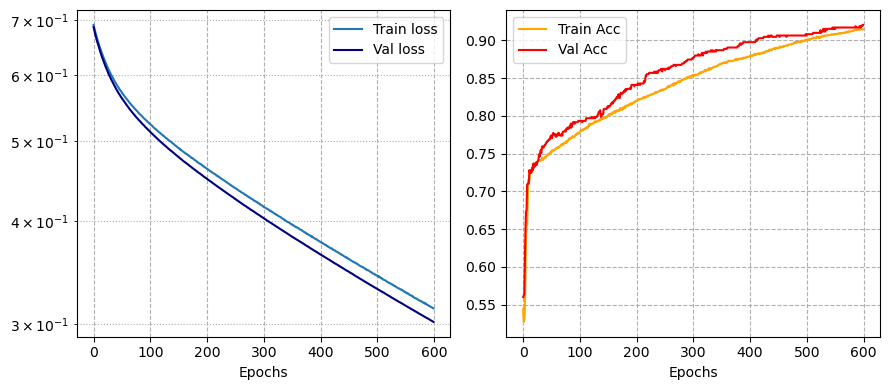

In [183]:
__, ax = plt.subplots(1,2,figsize=(9,4))

ax[0].semilogy([mt["loss"] for mt in mt_now], label="Train loss", color="C0")
ax[0].semilogy([mt["val_loss"] for mt in mt_now], label="Val loss", color="navy")

ax[1].plot([mt["acc"] for mt in mt_now], label="Train Acc", color="orange")
ax[1].plot([mt["val_acc"] for mt in mt_now], label="Val Acc", color="red")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(ls="--") for axi in ax]
ax[0].grid(which="minor", ls=":")
plt.tight_layout()

0/1(p):   0%|          | 0/29 [00:00<?, ?it/s]

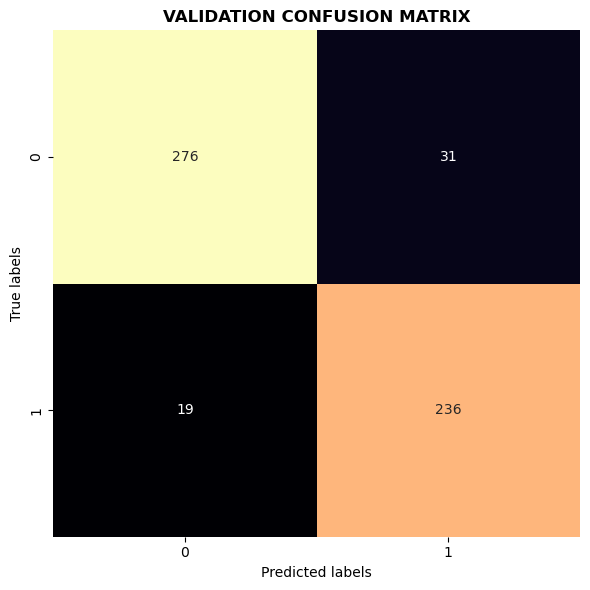

In [104]:
val_pred=np.argmax(trial_2.predict(data_key=torchbearer.VALIDATION_DATA).detach().numpy(),axis=1)
val_true=[v[1] for v in val_dataloader.dataset]

confM_val = confusion_matrix(y_true = val_true, y_pred = val_pred, labels=np.arange(2))

plt.figure(figsize=(6,6))
sns.heatmap(confM_val, annot=True, fmt="g", cbar=False, cmap="magma")
plt.title("VALIDATION CONFUSION MATRIX", weight="bold")
plt.ylabel("True labels")
plt.xlabel("Predicted labels")
plt.tight_layout()

In [89]:
trial_2.with_test_generator(synt_dataloader)
synt_pred = np.argmax(trial_2.predict().detach().numpy(),axis=1)

trial_2.with_test_generator(syntbstr_dataloader)
syntbstr_pred = np.argmax(trial_2.predict().detach().numpy(),axis=1)

trial_2.with_test_generator(test_dataloader)
test_pred = np.argmax(trial_2.predict().detach().numpy(),axis=1)

trial_2.with_test_generator(sars_dataloader)
sars_pred = np.argmax(trial_2.predict().detach().numpy(),axis=1)

0/1(p):   0%|          | 0/20 [00:00<?, ?it/s]

0/1(p):   0%|          | 0/20 [00:00<?, ?it/s]

0/1(p):   0%|          | 0/20 [00:00<?, ?it/s]

0/1(p):   0%|          | 0/20 [00:00<?, ?it/s]

In [90]:
accuracy_score(sars_pred, [1]*len(sars_pred))

0.97

In [91]:
accuracy_score(synt_pred, [1]*len(synt_pred))

0.66

In [92]:
accuracy_score(syntbstr_pred, [1]*len(syntbstr_pred))

0.03

In [93]:
accuracy_score(test_pred, y_test)

0.7461139896373057

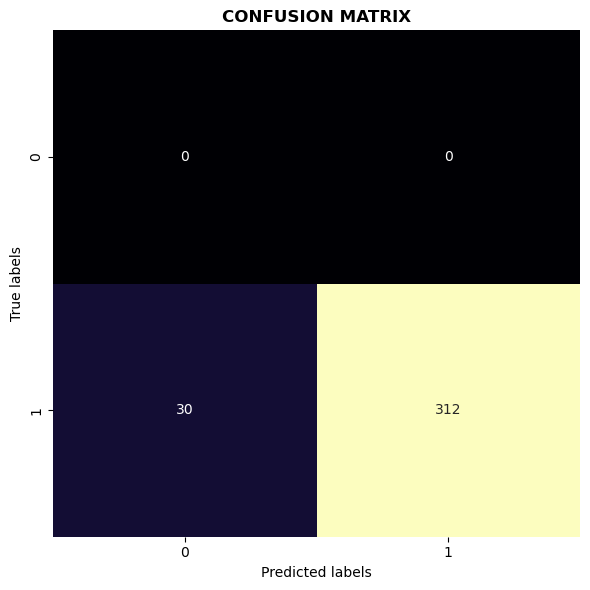

In [27]:
confM_val = confusion_matrix(y_true = y_test, y_pred = test_pred, labels=np.arange(2))

plt.figure(figsize=(6,6))
sns.heatmap(confM_val, annot=True, fmt="g", cbar=False, cmap="magma")
plt.title("CONFUSION MATRIX", weight="bold")
plt.ylabel("True labels")
plt.xlabel("Predicted labels")
plt.tight_layout()

In [27]:
predicted_lab=np.argmax(trial_2.predict(),axis=1).detach().numpy()

0/1(p):   0%|          | 0/6 [00:00<?, ?it/s]

Text(170.72222222222223, 0.5, 'Label')

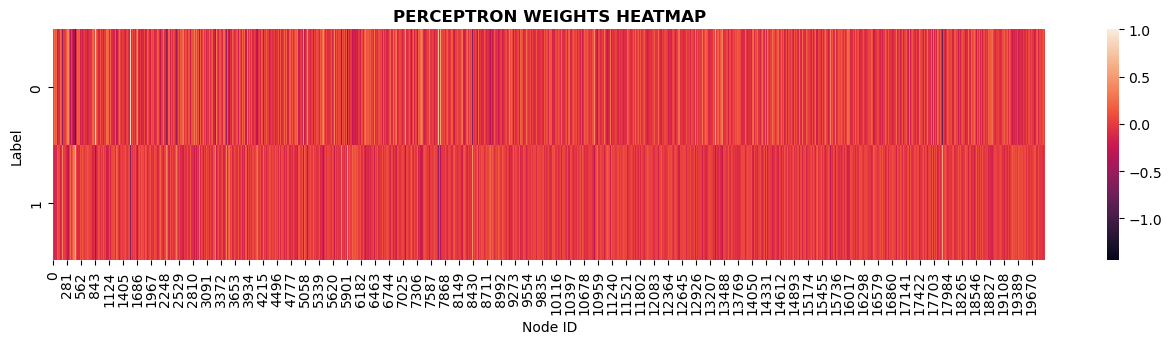

In [176]:
weights = model1.lin1.weight.data.detach().numpy()
weights = np.array([weights[i]/max(weights[i]) for i in range(len(weights))])
plt.figure(figsize=(16,3))
sns.heatmap(weights)
plt.title("PERCEPTRON WEIGHTS HEATMAP", fontweight="bold")
plt.xlabel("Node ID")
plt.ylabel("Label")

In [30]:
neg_weigh = np.argsort(weights[1])[:10]
pos_weigh = np.argsort(weights[1])[::-1][:10]

In [31]:
weigh_df = biostr_df.copy()

for i in range(2):
    weigh_df["W"+str(i)] = weights[i]
weigh_df["std"] = np.abs(weigh_df["W0"]-weigh_df["W1"])

In [33]:
weigh_df.sort_values("std", ascending=False)

,nodeID,nodeLabel,nodeSymbol,W0,W1,std
6535,6535,110368,MECP2,-1.342285,1.000000,2.342285
9764,9764,113935,HIST1H2BG,-1.267161,0.944601,2.211762
564,564,116463,CBX3,-1.190748,0.886614,2.077363
2039,2039,114020,NCK2,-1.123151,0.836625,1.959776
5570,5570,119470,RSRC1,-1.116921,0.832498,1.949419
...,...,...,...,...,...,...
16265,16265,126295,NUDT16,-0.000561,-0.000485,0.000076
3877,3877,127029,PROCA1,0.000652,0.000726,0.000073
13220,13220,129399,AQP11,-0.000436,-0.000363,0.000073
11612,11612,108945,GGCX,0.000037,0.000072,0.000035


## All together

In [ ]:
biostr_df = pd.read_csv("../Data/data_BIOGRID/BIOGRID_homo_sapiens.nodes", sep=" ")
biostr_map = dict(zip(biostr_df["nodeID"], biostr_df["nodeSymbol"]))

synt_pred_list, syntbstr_pred_list, test_pred_list, sars_pred_list = [],[],[],[]
top_50 = []

for i in [75,77,78,90]:
    index_rem = np.loadtxt("../Data/MLRes/indexes/"+str(i)+"_index.txt", dtype=int)
    index_rem = (index_rem[index_rem<(len(X)//2)])+(len(X)//2)

    X_test = X[index_rem]
    y_test = y[index_rem]
    print(X_test.shape)
    print(np.mean(y_test)==1)

    X_train, X_val, y_train, y_val = train_test_split(X[np.delete(np.arange(len(X)), index_rem)], y[np.delete(np.arange(len(X)), index_rem)], test_size=0.1, random_state=42)

    print(X_train.shape)
    print(X_val.shape)
    
    mydat_train = AdjacencyDataset(X_train, y_train)
    mydat_val = AdjacencyDataset(X_val, y_val)
    mydat_test = AdjacencyDataset(X_test, y_test)

    train_dataloader = DataLoader(mydat_train, batch_size=20, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(mydat_val, batch_size=20, shuffle=False, num_workers=0)
    test_dataloader = DataLoader(mydat_test, batch_size=20, shuffle=False, num_workers=0)
    
    model1 = Model()
    model1 = model1.cpu()
    
    check_last = ModelCheckpoint('checkpoints/check_last_'+str(i)+'.pth')

    trial_2 = Trial(model1,
                     optim.Adam(model1.parameters(), lr=5e-04), 
                     nn.CrossEntropyLoss(), 
                     metrics=["loss", "acc"],
                     callbacks=[check_last])

    trial_2.with_generators(train_generator=train_dataloader, 
                      val_generator=val_dataloader, 
                      test_generator=test_dataloader)#val67_dataloader)

    mytrial = trial_2.run(epochs=600, verbose=1)
    
    #trial_2.with_test_generator(synt_dataloader)
    #np.savetxt(X=np.argmax(trial_2.predict().detach().numpy(),axis=1), fname="../Data/MLRes/synt_pred_list_"+str(i)+".txt", fmt="%d")
#
    #trial_2.with_test_generator(syntbstr_dataloader)
    #np.savetxt(X=np.argmax(trial_2.predict().detach().numpy(),axis=1), fname="../Data/MLRes/syntbstr_pred_list_"+str(i)+".txt", fmt="%d")

    #trial_2.with_test_generator(test_dataloader)
    #np.savetxt(X=np.argmax(trial_2.predict().detach().numpy(),axis=1), fname="../Data/MLRes/test_pred_list_"+str(i)+".txt", fmt="%d")

    #trial_2.with_test_generator(sars_dataloader)
    #np.savetxt(X=np.argmax(trial_2.predict().detach().numpy(),axis=1), fname="../Data/MLRes/sars_pred_list_"+str(i)+".txt", fmt="%d")
    
    
    weights = model1.lin1.weight.data.detach().numpy()
    weights = np.array([weights[i]/max(weights[i]) for i in range(len(weights))])
    
    weigh_df = biostr_df.copy()

    for j in range(2):
        weigh_df["W"+str(j)] = weights[j]
    weigh_df["std"] = np.abs(weigh_df["W0"]-weigh_df["W1"])
    
    weigh_df.sort_values("std", ascending=False).head(50)["nodeSymbol"].to_csv("to_50_"+str(i)+".csv", index=False)

In [61]:
trial_2.evaluate()

0/1(e):   0%|          | 0/29 [00:00<?, ?it/s]

{'val_loss': 0.48404461145401, 'val_acc': 0.7953736782073975}

In [13]:
def set_up_trial(X, ind):
    index_rem = np.loadtxt("../Data/MLRes/indexes/"+str(ind)+"_index.txt", dtype=int)
    index_rem = (index_rem[index_rem<(len(X)//2)])+(len(X)//2)

    X_test = X[index_rem]
    y_test = y[index_rem]
    X_train, X_val, y_train, y_val = train_test_split(X[np.delete(np.arange(len(X)), index_rem)], y[np.delete(np.arange(len(X)), index_rem)], test_size=0.1, random_state=42)
    
    mydat_train = AdjacencyDataset(X_train, y_train)
    mydat_val = AdjacencyDataset(X_val, y_val)
    mydat_test = AdjacencyDataset(X_test, y_test)

    train_dataloader = DataLoader(mydat_train, batch_size=20, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(mydat_val, batch_size=20, shuffle=False, num_workers=0)
    test_dataloader = DataLoader(mydat_test, batch_size=20, shuffle=False, num_workers=0)
     
    check_last = ModelCheckpoint('checkpoints/check_last_'+str(i)+'.pth')
    
    model = Model()
    model = model1.cpu()
    
    trial_now = Trial(model,
                      optim.Adam(model1.parameters(), lr=5e-04), 
                      nn.CrossEntropyLoss(), 
                      metrics=["loss", "acc"],
                      callbacks=[check_last])
    
    trial_now = trial_now.load_state_dict(state_dict=torch.load("checkpoints/check_last_"+str(ind)+".pth"))
   
    trial_now.with_generators(train_generator=train_dataloader, 
                              val_generator=val_dataloader, 
                              test_generator=test_dataloader)
    
    my_trial_now = trial_now.run(epochs=600, verbose=1)
    
    return trial_now, my_trial_now

In [34]:
tr_now, mt_now = set_up_trial(X, 90)

100%|##########| 600/600 [00:00<?, ?it/s]

In [35]:
np.argmax(tr_now.predict().detach().numpy(),axis=1).mean()

0/1(p):   0%|          | 0/18 [00:00<?, ?it/s]

0.8604651162790697

In [36]:
tr_now.with_test_generator(synt_dataloader)
np.argmax(tr_now.predict().detach().numpy(),axis=1).mean()

0/1(p):   0%|          | 0/18 [00:00<?, ?it/s]

0.6666666666666666

In [64]:
weights = tr_now.state["model"].lin1.weight.detach().numpy()
weights = np.array([weights[i]/max(weights[i]) for i in range(len(weights))])

weigh_df = biostr_df.copy()

for j in range(2):
    weigh_df["W"+str(j)] = weights[j]
weigh_df["std"] = np.abs(weigh_df["W0"]-weigh_df["W1"])

#weigh_df.sort_values("std", ascending=False).head(50)["nodeSymbol"]

<AxesSubplot: >

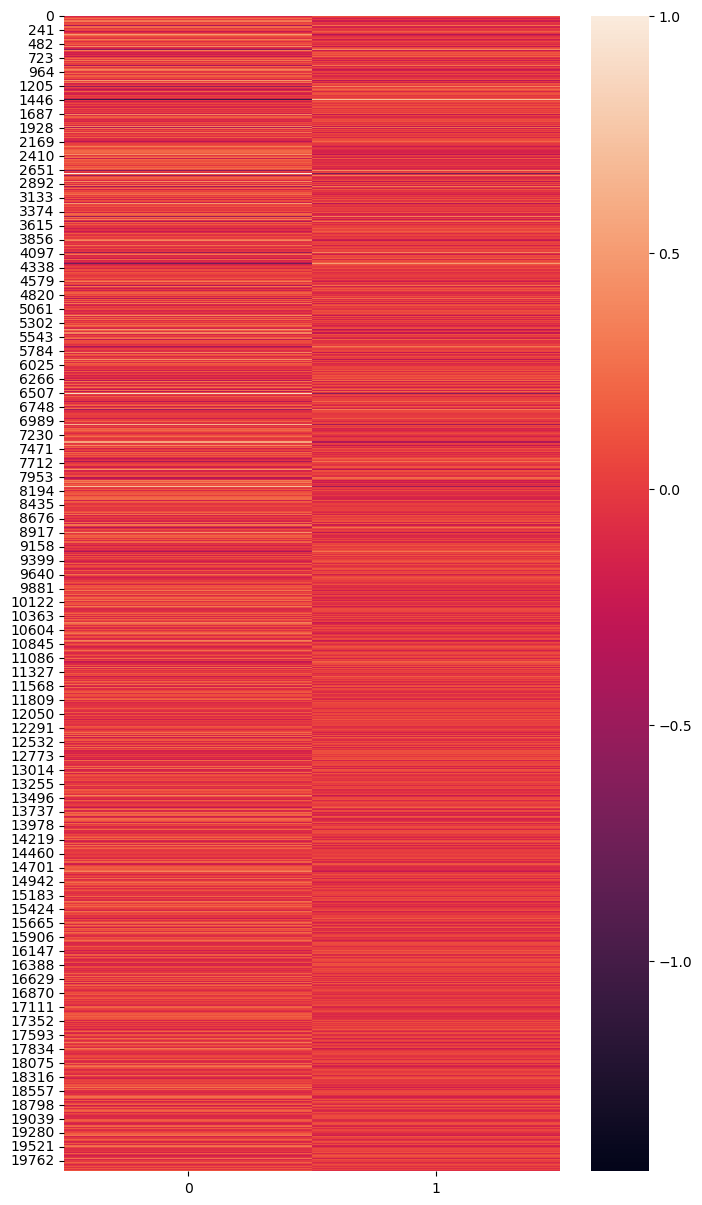

In [65]:
plt.figure(figsize=(8,15))
sns.heatmap(weights.T)

In [74]:
from scipy.stats import gaussian_kde

In [142]:
gauss = gaussian_kde(weigh_df[["nodeID","W1"]].T.to_numpy())
kde = gaussian_kde(weigh_df[["nodeID","W1"]].T.to_numpy())
density_1 = kde(weigh_df[["nodeID","W1"]].T.to_numpy())
gauss = gaussian_kde(weigh_df[["nodeID","W0"]].T.to_numpy())
kde = gaussian_kde(weigh_df[["nodeID","W0"]].T.to_numpy())
density_0 = kde(weigh_df[["nodeID","W0"]].T.to_numpy())

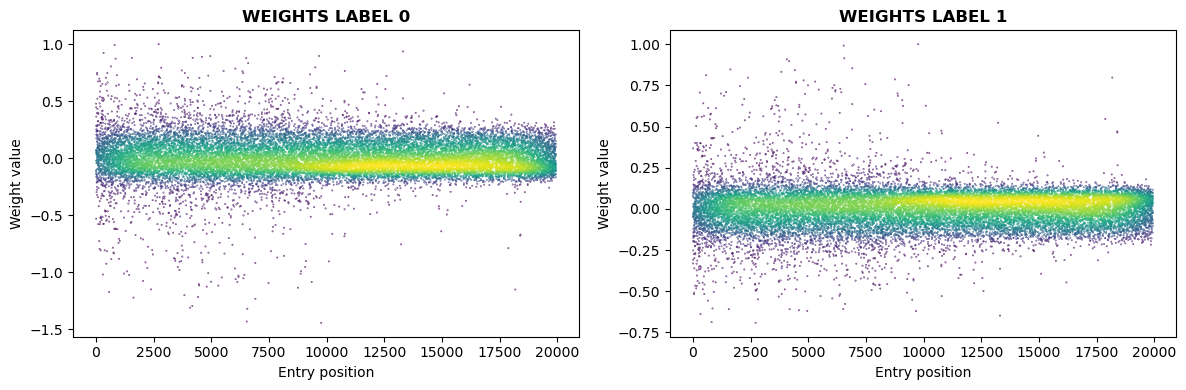

In [153]:
_, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].scatter(weigh_df["nodeID"], weights[0], c=density, cmap='viridis', s=0.1)
ax[0].set_title("WEIGHTS LABEL 0", fontweight="bold")
ax[0].set_xlabel("Entry position")
ax[0].set_ylabel("Weight value")
ax[1].scatter(weigh_df["nodeID"], weights[1], c=density, cmap='viridis', s=0.1)
ax[1].set_title("WEIGHTS LABEL 1", fontweight="bold")
ax[1].set_xlabel("Entry position")
ax[1].set_ylabel("Weight value")
plt.tight_layout()

In [18]:
top_50=[]
test_pred_list = []
for a in [28,43,44,67,75,77,78,90]:
    top_50.append(pd.read_csv("../Data/MLRes/to_50_"+str(a)+".csv").to_numpy())
    test_pred_list.append(np.loadtxt("../Data/MLRes/test_pred_list_"+str(a)+".txt"))

In [19]:
for i in range(len(test_pred_list)): print(np.mean(test_pred_list[i]))

0.9239766081871345
0.6016713091922006
0.8193384223918575
0.9297820823244553
0.7694300518134715
0.6820512820512821
0.4075067024128686
0.6627906976744186


In [20]:
top50_df = pd.DataFrame(np.unique(np.concatenate(top_50), return_counts=True)).T
top50_df.columns=["Prot", "Freq"]

In [130]:
print((",").join(top50_df[top50_df['Freq']>6]["Prot"].to_numpy()))#.sort_values("Freq", ascending=False)

CAPNS1,CBX3,CTBP1,DNTTIP1,DYRK1B,FAM60A,FBXO3,GATA4,HIPK2,HIST1H2BG,HIST2H3A,HOXB1,LZTS2,MECP2,MEIS1,MYB,MYBL1,NCK2,NKX2-1,NKX2-5,NLK,NPPA,NPSR1,PHF12,PPM1D,RASSF5,RGMA,RSRC1,SAP30L,SENP1,SENP2,SKI,SP100,SUV39H2,TAF6L,TP53INP1,TRIM29,WDR31,ZBTB4,ZNF217


In [23]:
lim = 10
inters = [top_50[0][:lim]]

for i in range(1,len(top_50)):
    inters = np.intersect1d(inters, top_50[i][:lim])

In [24]:
inters

array(['HIST1H2BG', 'MECP2'], dtype=object)

# Random Forest

In [164]:
def random_tree_MINE(X, ind, max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features, criterion, what_return="score"):
    num_features = X.shape[1]
    
    index_rem = np.loadtxt("../Data/MLRes/indexes/"+str(ind)+"_index.txt", dtype=int)
    index_rem = (index_rem[index_rem<(len(X)//2)])+(len(X)//2)

    X_test = X[index_rem]
    y_test = y[index_rem]
    
    X_train, X_val, y_train, y_val = train_test_split(X[np.delete(np.arange(len(X)), index_rem)], y[np.delete(np.arange(len(X)), index_rem)], test_size=0.1, random_state=42)

    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators,
                                           max_depth=max_depth, 
                                           min_samples_leaf=min_samples_leaf, 
                                           min_samples_split=min_samples_split,
                                           max_features=max_features,
                                           criterion=criterion
    )

    # Fit the classifier to the input data
    rf_classifier.fit(X_train, y_train)

    y_val_pred = rf_classifier.predict(X_val)
    y_train_pred = rf_classifier.predict(X_train)
    if what_return=="score":
        return accuracy_score(y_val, y_val_pred)
    else:
        
        # Calculate the accuracy of the model on the training data
        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        # Classify the new sample
        predicted_class = rf_classifier.predict(X_test)
        
        importance_scores = rf_classifier.feature_importances_

        return {"Model": rf_classifier,
                "train_pred": y_train_pred,
                "train_true": y_train,
                "train_accuracy": train_accuracy,
                "val_pred": y_val_pred,
                "val_true": y_val,
                "val_accuracy": val_accuracy,
                "test_pred": predicted_class,
                "scores": importance_scores}

In [162]:
result['Model'].n_estimators

20

In [165]:
scores_list = []

for i in [28,43,44,67,75,77,78,90]:
    print("Random forest for", i)
    result = random_tree_MINE(X=X,
                              ind=i,
                              n_estimators=100,
                              max_depth=None, 
                              min_samples_split=2, 
                              min_samples_leaf=1,
                              max_features="sqrt",
                              criterion="entropy",
                              what_return="all")
    sars_pred = result['Model'].predict(X_pred)
    synt_pred = result['Model'].predict(X_synt)
    scores_list.append(biostr_df["nodeSymbol"][result['scores'].argsort()[::-1]][:50].to_numpy())
    print("%.3f & %.3f & %.3f & %.3f & %.3f" %(result['train_accuracy'], result['val_accuracy'], result['test_pred'].mean(), sars_pred.mean(), synt_pred.mean()))

Random forest for 28
1.000 & 0.949 & 0.974 & 0.720 & 0.820
Random forest for 43
1.000 & 0.947 & 0.838 & 0.920 & 0.780
Random forest for 44
1.000 & 0.939 & 0.906 & 0.660 & 0.490
Random forest for 67
1.000 & 0.945 & 0.978 & 0.740 & 0.660
Random forest for 75
1.000 & 0.959 & 0.873 & 0.800 & 0.580
Random forest for 77
1.000 & 0.964 & 0.890 & 0.850 & 0.700
Random forest for 78
1.000 & 0.956 & 0.442 & 0.920 & 0.830
Random forest for 90
1.000 & 0.963 & 0.890 & 0.740 & 0.830


In [167]:
scores_df = pd.DataFrame(np.unique(np.concatenate(scores_list), return_counts=True)).T
print((", ").join(scores_df[scores_df[1]>6][0].to_numpy()))

CBX4, CREB1, CTBP1, DYRK1B, H2AFY, HIPK2, HIST1H2BG, HIST1H2BH, HIST1H3A, HIST2H2BE, MECP2, MYB, NKX2-1, NLK, NTRK1, SENP1, SKI


In [102]:
result = random_tree_MINE(X=X,
                          ind=43,
                            n_estimators=100,
                            max_depth=None, 
                            min_samples_split=2, 
                            min_samples_leaf=1,
                            max_features="sqrt",
                            criterion="entropy",
                            what_return="all")

In [103]:
y_val_pred = result["val_pred"]
y_test_pred = result["test_pred"]

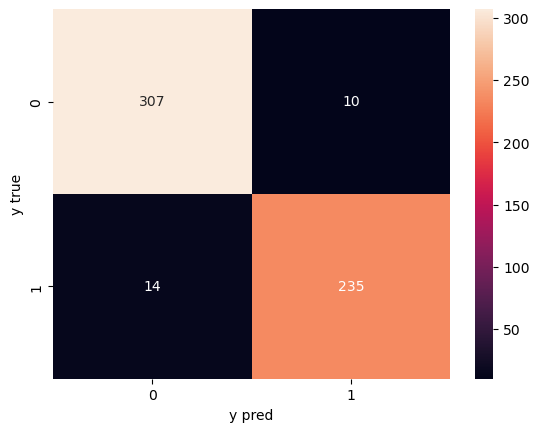

In [107]:
sns.heatmap(confusion_matrix(y_pred=result["val_pred"], y_true=result["val_true"]), annot=True, fmt="d")
plt.xlabel("y pred")
plt.ylabel("y true")
plt.show()

In [146]:
num_onco_sure = np.concatenate([[0]*1000,[1]*1000,[2]*1000])

In [148]:
np.unique(y_test_pred-num_onco_sure, return_counts=True)

(array([-1,  0,  1,  2]), array([  72, 1219, 1618,   91]))

In [116]:
scores_df = biostr_df.copy()
scores_df["scores"] = result["scores"]
scores_df.sort_values("scores", ascending=False).head(20)

,nodeID,nodeLabel,nodeSymbol,scores
3150,3150,113945,HIST2H2BE,0.008538
427,427,110969,NTRK1,0.006316
4073,4073,118815,HIPK2,0.005745
6560,6560,119685,NLK,0.005620
6432,6432,112936,NKX2-1,0.005295
8578,8578,123000,NANOG,0.004961
7588,7588,113946,HIST1H3A,0.004847
4710,4710,109269,H2AFZ,0.004704
6910,6910,118930,SENP1,0.004407
6535,6535,110368,MECP2,0.004232


In [54]:
most_imp_RF

array(['CTBP1', 'AXIN1', 'MYC', 'HIPK2', 'NTRK1', 'HIST1H2BN',
       'HIST1H2BK', 'CDH1', 'HIST1H3A', 'MECP2', 'HIST1H2BG', 'HIST2H2BE',
       'DAXX', 'NLK', 'DYRK1B', 'PIAS1', 'CREB1', 'H2BFS', 'TP73', 'RPN2',
       'SENP1', 'CBX4', 'KAT5', 'H2AFZ', 'H2AFY', 'NKX2-1', 'RBBP5',
       'CDH2', 'HMGA1', 'PML', 'MAPK1', 'TMEM17', 'HIST1H2BH', 'RBPJ',
       'SKI', 'SUMO2', 'SP100', 'UBE2I', 'RPS5', 'HDAC8', 'MLH1',
       'H2AFB1', 'SMARCA5', 'UBE2G2', 'HIST1H2BD', 'TP53INP1', 'POLR2L',
       'MYB', 'HIST2H3PS2', 'TPT1'], dtype=object)

In [179]:
np.savetxt(X=np.intersect1d(most_imp_PERC, most_imp_RF), fname="../Data/ClassificationData_4vir/inters.txt", fmt="%s")

In [180]:
np.savetxt(X=most_imp_PERC, fname="../Data/ClassificationData_4vir/PERC.txt", fmt="%s")

In [181]:
np.savetxt(X=most_imp_RF, fname="../Data/ClassificationData_4vir/RF.txt", fmt="%s")

In [184]:
enr_inters = gp.enrichr(gene_list="../Data/ClassificationData_4vir/RF.txt", # or "./tests/data/gene_list.txt",
                          gene_sets=['KEGG_2021_Human'],
                          organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                          outdir=None # don't write to disk
                          )

In [185]:
enr_inters.results.sort_values("Adjusted P-value")

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Cell adhesion molecules,3/148,0.006035,0.295731,0,0,8.718269,44.551440,CDH4;CLDN7;CDH15
20,KEGG_2021_Human,TNF signaling pathway,1/112,0.245071,0.482241,0,0,3.647546,5.129202,RPS6KA4
21,KEGG_2021_Human,Leukocyte transendothelial migration,1/114,0.248862,0.482241,0,0,3.582626,4.982914,CLDN7
22,KEGG_2021_Human,FoxO signaling pathway,1/131,0.280343,0.482241,0,0,3.111460,3.956968,NLK
23,KEGG_2021_Human,Dopaminergic synapse,1/132,0.282154,0.482241,0,0,3.087553,3.906683,SLC6A3
25,KEGG_2021_Human,Apelin signaling pathway,1/137,0.291143,0.482241,0,0,2.973289,3.668867,MEF2B
26,KEGG_2021_Human,Breast cancer,1/147,0.308789,0.482241,0,0,2.768242,3.252949,WNT7A
19,KEGG_2021_Human,Alzheimer disease,2/369,0.235437,0.482241,0,0,2.223320,3.215609,WNT7A;ND4
27,KEGG_2021_Human,Retrograde endocannabinoid signaling,1/148,0.310530,0.482241,0,0,2.749271,3.215201,ND4
29,KEGG_2021_Human,mTOR signaling pathway,1/154,0.320885,0.482241,0,0,2.640656,3.001559,WNT7A


In [160]:
def objective(trial):

    # set the range of the transformations to apply to the image
    hyperparameters = [
        #trial.suggest_int("n_estimators", 50,150),
        trial.suggest_int("max_depth", 1, 100),
        trial.suggest_int("min_samples_split", 2,10),
        trial.suggest_int("min_samples_leaf", 1,10),
        trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    ]
    
    return random_tree_MINE(X=X,
                            ind=77,
                            n_estimators = 100,
                            max_depth=hyperparameters[0], 
                            min_samples_split=hyperparameters[1], 
                            min_samples_leaf=hyperparameters[2],
                            max_features=hyperparameters[3],
                            criterion = hyperparameters[4])

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
sampler = TPESampler(seed=12345)
study = optuna.create_study(study_name="random tree", direction="maximize", pruner=pruner, sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.INFO)
study.optimize(objective, n_trials=10)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("   Max IoU: {}".format(trial.value))

print("   Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-06-05 15:18:03,019] A new study created in memory with name: random tree
[I 2023-06-05 15:18:06,862] Trial 0 finished with value: 0.9411764705882353 and parameters: {'max_depth': 93, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.9411764705882353.
[I 2023-06-05 15:18:10,717] Trial 1 finished with value: 0.946524064171123 and parameters: {'max_depth': 75, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'criterion': 'log_loss'}. Best is trial 1 with value: 0.946524064171123.
[I 2023-06-05 15:18:14,532] Trial 2 finished with value: 0.9429590017825312 and parameters: {'max_depth': 81, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.946524064171123.
[I 2023-06-05 15:18:18,339] Trial 3 finished with value: 0.9358288770053476 and parameters: {'max_depth': 44, 'min_samples_split': 8, 'min_samples_leaf': 10, 'ma

Number of finished trials: 10
Best trial:
   Max IoU: 0.9572192513368984
   Params: 
    max_depth: 82
    min_samples_split: 6
    min_samples_leaf: 9
    max_features: log2
    criterion: entropy


In [38]:
res_df = pd.DataFrame({"Prot": node_map_df.loc[sorted_indices]["Prot"], "Score": np.sort(importance_scores)[::-1]})
res_df[res_df["Score"]>1e-3]

,Prot,Score
9317,CDH6,0.002634
2194,ATRX,0.002410
9010,APC2,0.002408
9318,CDH9,0.002311
8946,FAM171B,0.002292
...,...,...
7950,SCEL,0.001016
8658,SBSN,0.001010
8767,EPS8L1,0.001008
1206,HIST2H3PS2,0.001004


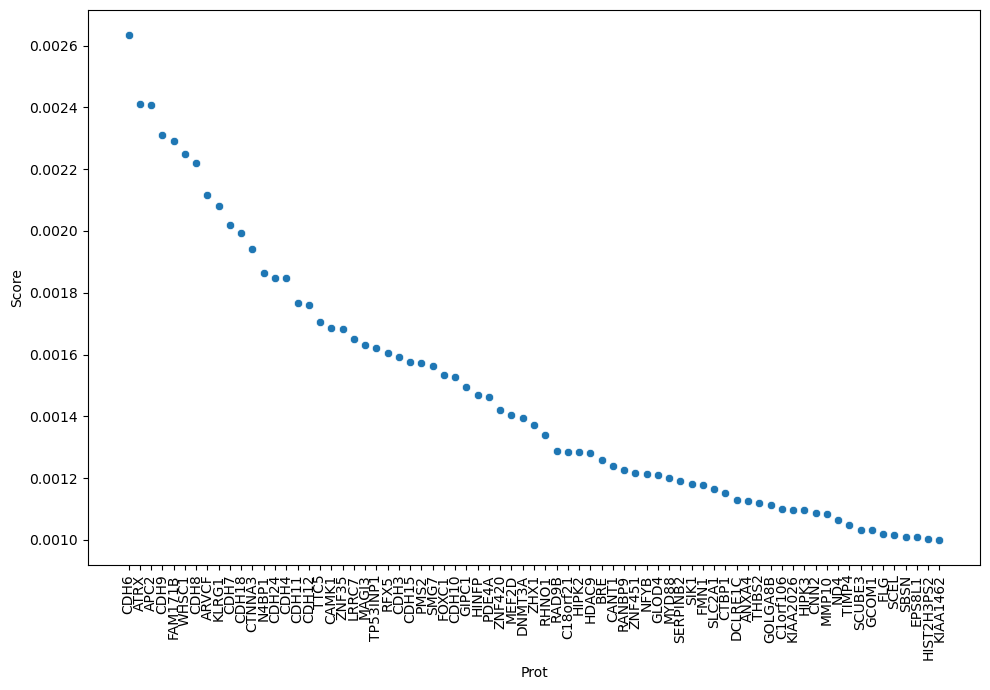

In [39]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=res_df[res_df["Score"]>1e-3], x="Prot", y="Score")
plt.xticks(rotation=90)
plt.tight_layout()

## Enrichment

In [48]:
enr_dir = os.listdir("../Data/pathways/")
enr_dir_train = enr_dir[:-2]
print(enr_dir_train)
enr_dir_pred = enr_dir[-2:-1]
enr_dir_pred

['n4o', 'o1n', 'n6o', 'n3o', 'n5o', 'n1o', 'n2o', 'n']


['n1s']

In [110]:
path_list = []
for t in enr_dir:
    for i in os.listdir("../Data/pathways/"+t):
        path_list= np.concatenate([path_list, pd.read_csv("../Data/pathways/"+t+"/"+i)["Term"].to_numpy()])
        path_list = np.unique(path_list)

path_dict = dict(zip(path_list, np.arange(len(path_list))))

#training samples
X = []
for t in enr_dir_train:
    for i in os.listdir("../Data/pathways/"+t):
        ex_df = pd.read_csv("../Data/pathways/"+t+"/"+i)
        path_arr = np.zeros(len(path_list))
        path_arr[np.array(itemgetter(*ex_df["Term"])(path_dict))]= ex_df["Adjusted P-value"].map(lambda x: -np.log10(x))
        X.append(path_arr)
X=np.array(X)
print(X.shape)

#training samples labels
label_dict = dict(zip(top_dir_train, [4,7,6,3,5,1,2,0]))

y = []
for t in enr_dir_train:
    y.append([label_dict[t]]*len(os.listdir("../Data/pathways/"+t)))

y = np.concatenate(y)
print(y.shape)

# samples with sarscov2
X_pred = []
for t in enr_dir_pred:
    for i in os.listdir("../Data/pathways/"+t):
        ex_df = pd.read_csv("../Data/pathways/"+t+"/"+i)
        path_arr = np.zeros(len(path_list))
        path_arr[np.array(itemgetter(*ex_df["Term"])(path_dict))]= ex_df["Adjusted P-value"].map(lambda x: -np.log10(x))
        X_pred.append(path_arr)

X_pred = np.array(X_pred)
print(X_pred.shape)

(1089, 203)
(1089,)
(135, 203)


In [111]:
importance_scores_list = []
predicted_class_list = []
acc_list = []


def random_tree_MINE(X,y)
    num_features = X.shape[1]


    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier()

    # Fit the classifier to the input data
    rf_classifier.fit(X_train, y)

    y_pred = rf_classifier.predict(X_train)

    # Calculate the accuracy of the model on the training data
    accuracy = accuracy_score(y, y_pred)
    acc_list.append(accuracy)
    # Classify the new sample
    predicted_class = rf_classifier.predict(X_pred)
    predicted_class_list.append(predicted_class)

    #print("Mean predicted class:", np.mean(predicted_class))

    importance_scores = rf_classifier.feature_importances_
    importance_scores_list.append(importance_scores)

    # Sort the features by importance in descending order
    sorted_indices = np.argsort(importance_scores)[::-1]

    # Print the top 10 most important features
    top_features = 3
    #print("Top", top_features, "features:")
    #for i in range(top_features):
    #    feature_index = sorted_indices[i]
    #    print("Feature", node_map_df.loc[feature_index]["Prot"], "- Importance:", importance_scores[feature_index])

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


In [112]:
acc_list

[0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681]

In [118]:
rf_classifier

0.0

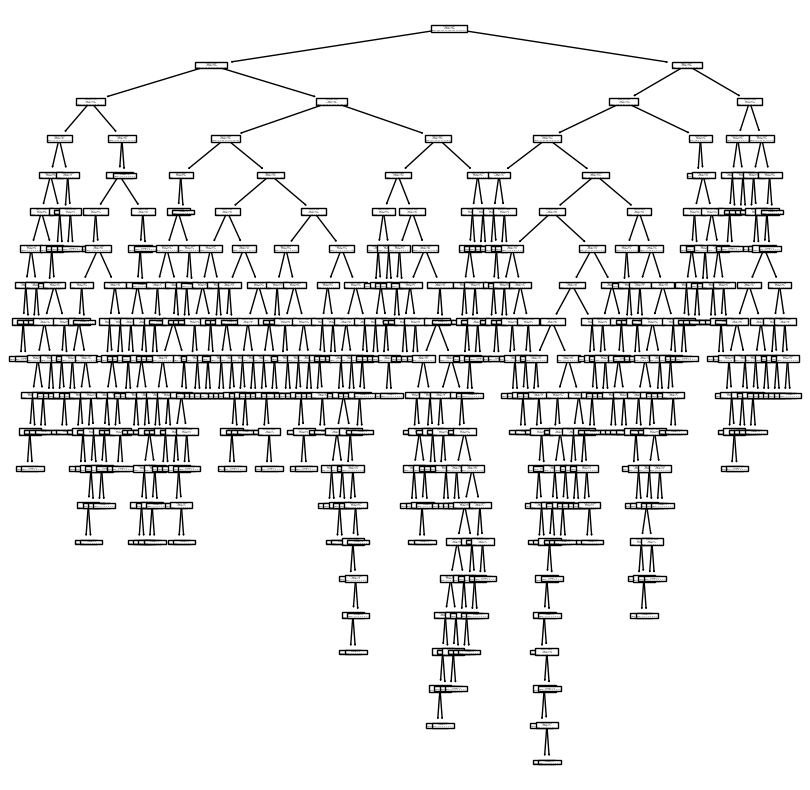

In [113]:
from sklearn import tree
# Extract the individual decision tree
decision_tree = rf_classifier.estimators_[0]

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the decision tree
tree.plot_tree(decision_tree, ax=ax)

# Show the plot
plt.show()